**Learning Python -- The Programming Language for Artificial Intelligence and Data Science**

**Lecture: Gradient Descent**

By Allen Y. Yang, PhD

(c) Copyright Intelligent Racing Inc., 2021-2024. All rights reserved. Materials may NOT be distributed or used for any commercial purposes.

# Keywords

* **Penalty Function**: A function that measures the error or cost of a solution, which we aim to minimize to find optimal parameters.
* **Gradient**: A vector of partial derivatives that points in the direction of steepest increase of a function.
* **Gradient Descent**: An iterative optimization algorithm that moves in the negative gradient direction to find local minima.
* **Learning Rate**: A scalar parameter (λ) that controls the step size in gradient descent updates.
* **Line Search**: A technique to adaptively choose the learning rate by testing multiple values and selecting the one that gives the best improvement.
* **Local Minimum**: A point where the function value is lower than all nearby points, but may not be the global minimum.
* **Convergence**: The process by which an iterative algorithm approaches a stable solution.

# Introduction: From Algebra to Statistics

In previous lectures, we've learned how to solve linear systems algebraically. For example, if we have a system like:

$$\begin{bmatrix} 1 & 1 \\ 4 & 2 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} = \begin{bmatrix} 35 \\ 110 \end{bmatrix}$$

We can solve it exactly using matrix inverse. However, in real-world applications, measurements are noisy. What if we have many noisy observations that don't perfectly fit a linear model?

This is where statistical methods and optimization come in. Instead of finding an exact solution, we find the "best" solution that minimizes the errors across all observations.

# The Linear Least Squares Problem

Consider fitting a line $y = ax + b$ to noisy data points $(x_i, y_i)$. Since the data is noisy:

$$y_i \approx ax_i + b$$

We define a **penalty function** (also called cost or loss function) that measures how well our parameters $(a, b)$ fit the data:

$$f(a, b) = \frac{1}{2m} \sum_{i=1}^{m} (y_i - ax_i - b)^2$$

Our goal is to find $(a^*, b^*)$ that minimizes this penalty function.

# Brute-Force Search

Let's first visualize the problem by trying a brute-force approach - testing many possible values of $(a, b)$ and finding the minimum:

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Brute-force optimal parameters: a = 2.000, b = -1.000


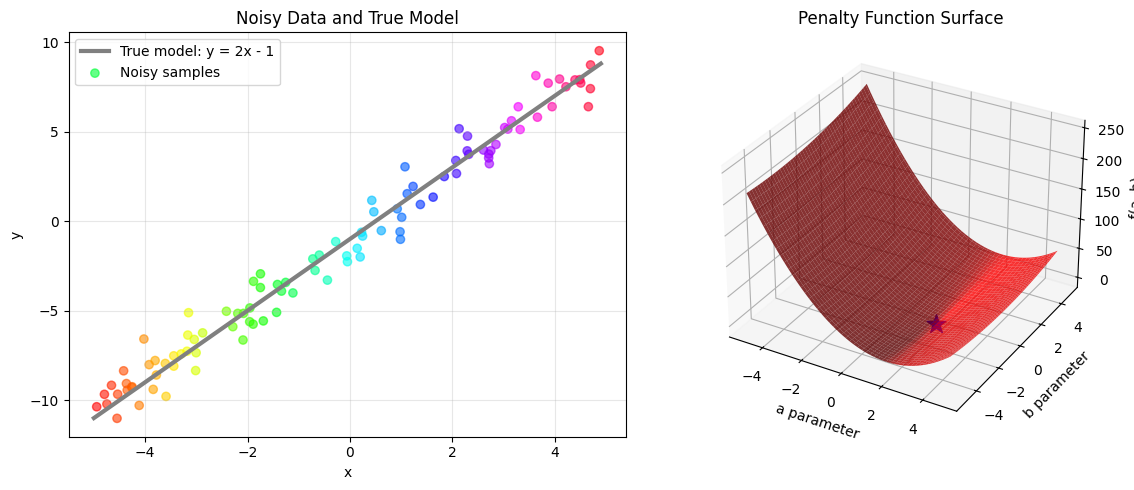

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Set random seed for reproducibility
np.random.seed(42)

# Generate noisy samples from the true model: y = 2x - 1
sample_count = 100
x_sample = 10*np.random.random(sample_count)-5
y_sample = 2*x_sample - 1 + np.random.normal(0, 1.0, sample_count)

# Define the penalty function
def penalty(para_a, para_b):
    squares = (y_sample - para_a*x_sample - para_b)**2
    return 1/2/sample_count*np.sum(squares)

# Create figure with two subplots
fig = plt.figure(figsize=(12, 5))

# Subplot 1: Show the noisy samples and true line
ax1 = fig.add_subplot(1,2,1)
x = np.arange(-5, 5, 0.1)
y = 2*x - 1
ax1.plot(x, y, 'gray', linewidth = 3, label='True model: y = 2x - 1')
ax1.scatter(x_sample, y_sample, c = x_sample, cmap = 'hsv', alpha=0.6, label='Noisy samples')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Noisy Data and True Model')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: Show the penalty function surface
ax2 = fig.add_subplot(1,2,2, projection = '3d')

# Create a grid of (a, b) values
a_arr, b_arr = np.meshgrid(np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1))

# Compute penalty function value for each (a, b) pair
func_value = np.zeros(a_arr.shape)
for ax in range(a_arr.shape[0]):
    for ay in range(a_arr.shape[1]):
        func_value[ax, ay] = penalty(a_arr[ax, ay], b_arr[ax, ay])

# Plot the surface
ax2.plot_surface(a_arr, b_arr, func_value, color = 'red', alpha = 0.8)
ax2.set_xlabel('a parameter')
ax2.set_ylabel('b parameter')
ax2.set_zlabel('f(a, b)')
ax2.set_title('Penalty Function Surface')

# Find and mark the minimum value
optimal_x, optimal_y = np.where(func_value == np.amin(func_value))
print(func_value == np.amin(func_value))
print(f"Brute-force optimal parameters: a = {a_arr[optimal_x, optimal_y][0]:.3f}, b = {b_arr[optimal_x, optimal_y][0]:.3f}")
ax2.scatter(a_arr[optimal_x, optimal_y], b_arr[optimal_x, optimal_y], 
    func_value[optimal_x, optimal_y], marker = '*', s=200, c='blue')

plt.tight_layout()
plt.show()

The brute-force approach works but is inefficient - we evaluated the function at 10,000 points! Can we find the minimum more efficiently?

# Gradient Descent Algorithm

Instead of testing all possible values, gradient descent follows the steepest downhill direction. The gradient of our penalty function is:

$$\nabla f(a, b) = \left[\frac{\partial f}{\partial a}, \frac{\partial f}{\partial b}\right]$$

For our linear least squares problem:

$$\frac{\partial f}{\partial a} = \frac{1}{m} \sum_{i=1}^{m} (-x_i)(y_i - ax_i - b)$$

$$\frac{\partial f}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} -(y_i - ax_i - b)$$

The gradient descent update rule is:

$$a_{t+1} = a_t - \lambda \frac{\partial f}{\partial a}$$
$$b_{t+1} = b_t - \lambda \frac{\partial f}{\partial b}$$

where $\lambda$ is the learning rate.

Learning rate 0.001: Converged to a = 1.992, b = -0.006 in 1573 steps
Learning rate 0.01: Converged to a = 1.958, b = -0.916 in 390 steps
Learning rate 0.1: Converged to a = 1.954, b = -1.006 in 61 steps
Learning rate 0.2: Converged to a = 1.954, b = -1.014 in 38 steps


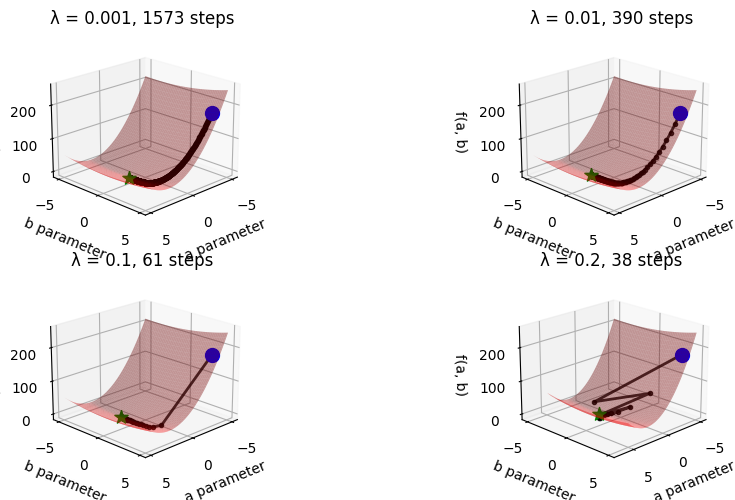

In [2]:
# Gradient descent implementation
def grad(aa):
    """Calculate gradient at point aa = [a, b]"""
    grad_aa = np.zeros(2)
    update_vector = (y_sample - aa[0] * x_sample - aa[1])
    grad_aa[0] = - 1/sample_count * x_sample.dot(update_vector)
    grad_aa[1] = - 1/sample_count * np.sum(update_vector)
    return grad_aa

# Visualization of gradient descent path
fig = plt.figure(figsize=(12, 5))

# Run gradient descent with different learning rates
learning_rates = [0.001, 0.01, 0.1, 0.2]
colors = ['blue', 'green', 'orange', 'red']

for idx, learn_rate in enumerate(learning_rates):
    ax = fig.add_subplot(2, 2, idx+1, projection='3d')
    
    # Plot the surface
    ax.plot_surface(a_arr, b_arr, func_value, color='red', alpha=0.4)
    
    # Initialize
    aa = np.array([-4, 4])  # Starting point
    delta = np.inf
    epsilon = 0.001
    step_count = 0
    max_steps = 2000
    
    # Store path for visualization
    path = [aa.copy()]
    
    # Gradient descent loop
    while delta > epsilon and step_count < max_steps:
        aa_next = aa - learn_rate * grad(aa)
        delta = np.linalg.norm(aa - aa_next)
        aa = aa_next
        step_count += 1
        path.append(aa.copy())
    
    # Plot the path
    path = np.array(path)
    z_path = [penalty(p[0], p[1]) for p in path]
    
    # Plot starting and ending points
    ax.scatter(path[0, 0], path[0, 1], z_path[0], c='blue', s=100, marker='o', label='Start')
    ax.scatter(path[-1, 0], path[-1, 1], z_path[-1], c='green', s=100, marker='*', label='End')
    
    # Plot the descent path
    ax.plot(path[:, 0], path[:, 1], z_path, 'ko-', linewidth=2, markersize=3, alpha=0.8)
    
    ax.set_xlabel('a parameter')
    ax.set_ylabel('b parameter')
    ax.set_zlabel('f(a, b)')
    ax.set_title(f'λ = {learn_rate}, {step_count} steps')
    ax.view_init(elev=20, azim=45)
    
    print(f"Learning rate {learn_rate}: Converged to a = {aa[0]:.3f}, b = {aa[1]:.3f} in {step_count} steps")

plt.tight_layout()
plt.show()

# Effect of Learning Rate

As we can see from the above examples:
- **Small learning rate** (λ = 0.001): Converges slowly but steadily
- **Medium learning rate** (λ = 0.01, 0.1): Good balance between speed and stability
- **Large learning rate** (λ = 0.2): Can oscillate or even diverge

Choosing the right learning rate is crucial for efficient convergence!

# Gradient Descent with Line Search

Instead of using a fixed learning rate, we can adaptively choose the best rate at each step:

Line Search Optimal result: a = 1.954, b = -1.009
Step Count: 31


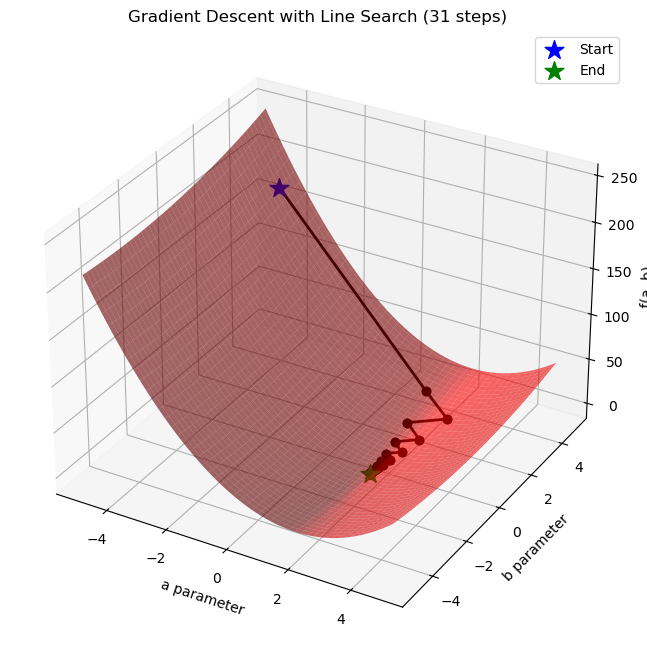

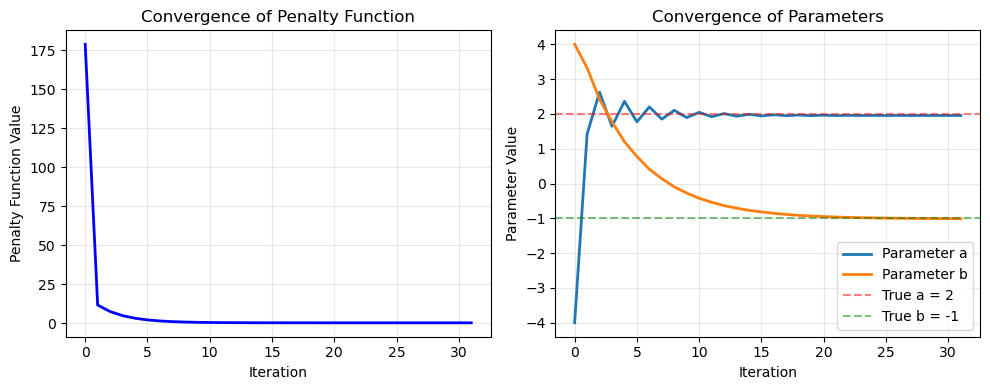

In [3]:
# Gradient descent with line search
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1, projection='3d')

# Plot the surface
ax.plot_surface(a_arr, b_arr, func_value, color='red', alpha=0.6)

# Initialize
aa = np.array([-4, 4])
value = penalty(aa[0], aa[1])
ax.scatter(aa[0], aa[1], value, c='b', s=200, marker='*', label='Start')

# Parameters
epsilon = 0.00001
learn_rates = [0.2, 0.1, 0.05, 0.01]
max_iteration = 100
delta = value
iter = 0

# Store path
path = [aa.copy()]
values = [value]

# Update loop with line search
while delta > epsilon and iter < max_iteration:
    delta = 0
    aa_next = aa
    
    # Try different learning rates and pick the best
    for rate in learn_rates:
        aa_try = aa - rate * grad(aa)
        value_next = penalty(aa_try[0], aa_try[1])
        if value_next < value and value - value_next > delta:
            delta = value - value_next
            aa_next = aa_try
    
    # Plot the step
    ax.plot([aa[0], aa_next[0]], [aa[1], aa_next[1]],
            [penalty(aa[0], aa[1]), penalty(aa_next[0], aa_next[1])], 'ko-', linewidth=2)
    
    aa = aa_next
    value = value - delta
    iter += 1
    path.append(aa.copy())
    values.append(value)

# Mark the final point
ax.scatter(aa[0], aa[1], penalty(aa[0], aa[1]), c='g', s=200, marker='*', label='End')

print(f'Line Search Optimal result: a = {aa[0]:.3f}, b = {aa[1]:.3f}')
print(f'Step Count: {iter}')

ax.set_xlabel('a parameter')
ax.set_ylabel('b parameter')
ax.set_zlabel('f(a, b)')
ax.set_title(f'Gradient Descent with Line Search ({iter} steps)')
ax.legend()
plt.show()

# Plot convergence
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(values, 'b-', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Penalty Function Value')
plt.title('Convergence of Penalty Function')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
path = np.array(path)
plt.plot(path[:, 0], label='Parameter a', linewidth=2)
plt.plot(path[:, 1], label='Parameter b', linewidth=2)
plt.axhline(y=2, color='r', linestyle='--', alpha=0.5, label='True a = 2')
plt.axhline(y=-1, color='g', linestyle='--', alpha=0.5, label='True b = -1')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.title('Convergence of Parameters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gradient Descent Limitations: Multiple Minima

Gradient descent finds a **local minimum**, which may not be the **global minimum**. Let's see an example with a more complex function:

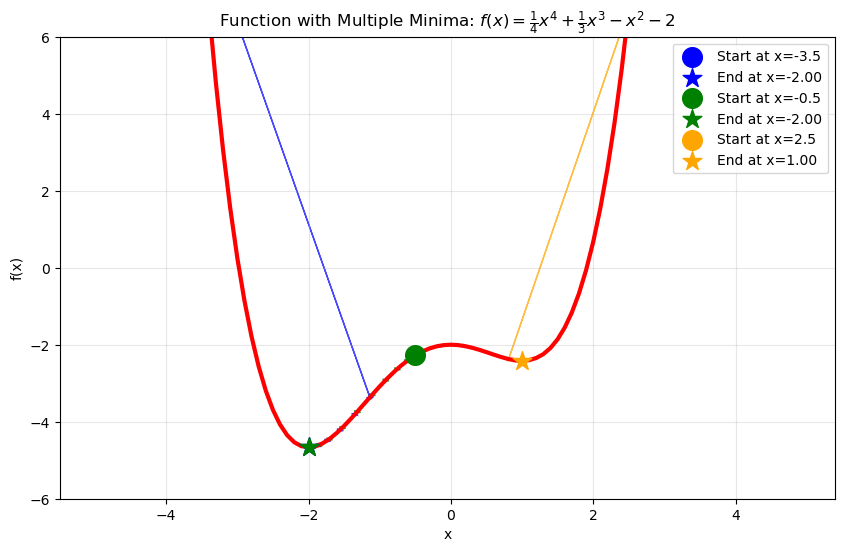


Key observation: Different starting points lead to different local minima!
This is a fundamental limitation of gradient descent.


In [4]:
# Define a function with multiple minima
def func(x):
    return 1/4*x**4 + 1/3*x**3 - x**2 - 2

def grad_func(x):
    return x**3 + x**2 - 2*x

# Plot the function
x = np.arange(-5, 5, 0.1)
y = func(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'r-', linewidth=3)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function with Multiple Minima: $f(x) = \\frac{1}{4}x^4 + \\frac{1}{3}x^3 - x^2 - 2$')
plt.grid(True, alpha=0.3)

# Run gradient descent from different starting points
starting_points = [-3.5, -0.5, 2.5]
colors = ['blue', 'green', 'orange']
learn_rate = 0.1
epsilon = 0.001

for start_x, color in zip(starting_points, colors):
    x_current = start_x
    x_history = [x_current]
    
    # Gradient descent
    for _ in range(100):
        x_next = x_current - learn_rate * grad_func(x_current)
        if abs(x_next - x_current) < epsilon:
            break
        x_current = x_next
        x_history.append(x_current)
    
    # Plot the path
    y_history = [func(x) for x in x_history]
    plt.scatter(x_history[0], y_history[0], c=color, s=200, marker='o', 
                label=f'Start at x={start_x:.1f}', zorder=5)
    plt.scatter(x_history[-1], y_history[-1], c=color, s=200, marker='*', 
                label=f'End at x={x_history[-1]:.2f}', zorder=5)
    
    # Draw arrows showing the descent path
    for i in range(0, len(x_history)-1, max(1, len(x_history)//10)):
        plt.arrow(x_history[i], y_history[i], 
                  x_history[i+1]-x_history[i], y_history[i+1]-y_history[i],
                  head_width=0.1, head_length=0.05, fc=color, ec=color, alpha=0.7)

plt.legend()
plt.ylim(-6, 6)
plt.show()

print("\nKey observation: Different starting points lead to different local minima!")
print("This is a fundamental limitation of gradient descent.")

# Summary

In this lecture, we learned about **Gradient Descent**, a fundamental optimization algorithm in machine learning:

1. **Penalty Functions**: We use these to measure how well our parameters fit the data
2. **Gradient Descent Algorithm**: 
   - Calculate the gradient (direction of steepest increase)
   - Move in the opposite direction (steepest decrease)
   - Repeat until convergence
3. **Learning Rate Selection**:
   - Too small: slow convergence
   - Too large: oscillation or divergence
   - Line search: adaptively choose the best rate
4. **Limitations**:
   - Only finds local minima
   - Result depends on initialization
   - May need multiple random starts

Gradient descent is the foundation for training neural networks and many other machine learning algorithms!

# Exercises

## Exercise 1
Implement a function that calculates the gradient of the penalty function $f(a, b) = \frac{1}{2m} \sum_{i=1}^{m} (y_i - ax_i - b)^2$ analytically. Verify your implementation by comparing with numerical gradients.

## Exercise 2
Generate a dataset with 50 points following $y = 3x + 2$ with Gaussian noise (standard deviation = 2). Use gradient descent to find the best-fit line parameters. Start from $(a, b) = (0, 0)$ and use learning rate $\lambda = 0.01$.

## Exercise 3
Implement a function that performs gradient descent with momentum. The update rule with momentum is:
$$v_{t+1} = \beta v_t + (1-\beta) \nabla f$$
$$\theta_{t+1} = \theta_t - \lambda v_{t+1}$$
where $\beta$ is the momentum parameter (typically 0.9). Compare convergence speed with and without momentum.

## Exercise 4
Create a visualization showing how the penalty function surface changes as the noise level in the data increases. Generate datasets with noise standard deviations of 0.5, 1.0, 2.0, and 4.0, and plot the corresponding penalty surfaces.

## Exercise 5
Debug the following gradient descent implementation:

In [ ]:
# This code has bugs - fix them!
def buggy_gradient_descent(x_data, y_data, learning_rate=0.01):
    a = 0
    b = 0
    n = len(x_data)
    
    for i in range(100):
        # Calculate gradients
        grad_a = sum((y_data - a*x_data - b) * x_data) / n
        grad_b = sum(y_data - a*x_data - b) / n
        
        # Update parameters
        a = a + learning_rate * grad_a
        b = b + learning_rate * grad_b
    
    return a, b

# Challenges

## Challenge 1
Implement a 2D visualization of gradient descent that shows:
- Contour lines of the penalty function
- The path taken by gradient descent
- An animation showing the descent process step by step
- A comparison of paths taken with different learning rates on the same plot

## Challenge 2
Implement adaptive learning rate methods:
1. **Gradient descent with decay**: $\lambda_t = \frac{\lambda_0}{1 + decay\_rate \times t}$
2. **AdaGrad**: Adapts learning rate based on historical gradients
3. **RMSprop**: Uses exponential moving average of squared gradients

Compare their performance on the same optimization problem and create a plot showing convergence rates.

## Challenge 3
Create a interactive widget (using ipywidgets or similar) that allows users to:
- Adjust the learning rate with a slider
- Choose different starting points by clicking on the penalty surface
- See the gradient descent path update in real-time
- Display convergence statistics (number of steps, final error, etc.)